In [11]:
# Libraries for ML work:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
import os
import findspark
from pyspark.sql import *
from pyspark import SparkConf

findspark.init()

conf = SparkConf()
# we need iceberg libraries and the nessie sql extensions
conf.set(
    "spark.jars.packages",
    f"org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.0.0,org.projectnessie:nessie-spark-extensions-3.3_2.12:0.44.0,software.amazon.awssdk:bundle:2.17.178,software.amazon.awssdk:url-connection-client:2.17.178",
)
# ensure python <-> java interactions are w/ pyarrow
conf.set("spark.sql.execution.pyarrow.enabled", "true")
conf.set("spark.sql.catalog.arctic.io-impl","org.apache.iceberg.aws.s3.S3FileIO")

# create catalog named arctic as an iceberg catalog
conf.set("spark.sql.catalog.arctic", "org.apache.iceberg.spark.SparkCatalog")

# tell the catalog that its a Nessie catalog
conf.set("spark.sql.catalog.arctic.catalog-impl", "org.apache.iceberg.nessie.NessieCatalog")

# set the location for the catalog to store data. Spark writes to this directory
conf.set("spark.sql.catalog.arctic.warehouse", "s3://bucket/")

# set the location of the Nessie/Arctic server.
conf.set("spark.sql.catalog.arctic.uri", "https://nessie.dremio.cloud/v1/..")

# default branch for Arctic catalog to work on
conf.set("spark.sql.catalog.arctic.ref", "main")

# Authentication mechanism. Here, we use AWS with BEARER
conf.set("spark.sql.catalog.arctic.authentication.type", "BEARER")
conf.set("spark.sql.catalog.arctic.authentication.token", "TOKEN")

# enable the extensions for both Nessie and Iceberg
conf.set(
    "spark.sql.extensions",
    "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions,org.projectnessie.spark.extensions.NessieSparkSessionExtensions",
)

# finally, start up the Spark server
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Running")

:: loading settings :: url = jar:file:/home/docker/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/docker/.ivy2/cache
The jars for the packages stored in: /home/docker/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.3_2.12 added as a dependency
org.projectnessie#nessie-spark-extensions-3.3_2.12 added as a dependency
software.amazon.awssdk#bundle added as a dependency
software.amazon.awssdk#url-connection-client added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-caf2c666-a736-4768-b6c8-3cf34e25ab3d;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.3_2.12;1.0.0 in central
	found org.projectnessie#nessie-spark-extensions-3.3_2.12;0.44.0 in central
	found org.scala-lang#scala-reflect;2.12.17 in central
	found org.projectnessie#nessie-spark-extensions-grammar;0.44.0 in central
	found org.projectnessie#nessie-spark-antlr-runtime;0.44.0 in central
	found org.antlr#antlr4-runtime;4.11.1 in central
	found org.projectnessie#nessie-spark-extensions-base_2.12;0.44.0 in central
	found org.projectness

22/11/23 18:32:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/23 18:33:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/23 18:33:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/23 18:33:45 ERROR Inbox: Ignoring error
java.lang.NullPointerException
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$register(BlockManagerMasterEndpoint.scala:579)
	at org.apache.spark.storage.BlockManagerMasterEndpoint$$anonfun$receiveAndReply$1.applyOrElse(BlockManagerMasterEndpoint.scala:121)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:103)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100)
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75)
	at org.apache.spark.rpc.netty.MessageLoop$$anon$1.run(MessageLoop.scala:41)
	at java.base/java.util.concurrent.Executo

In [3]:
# List out the branches in the Arctic catalog
spark.sql("LIST REFERENCES IN arctic").toPandas()

,refType,name,hash
0,Branch,ML_exp,fa0645499831b25f40ef66ab09219ab8db0d8d7f2a8ef9...
1,Branch,ML_exp_new,9de2ac3f702f1827f92d670477ff9c075de1f637a747f8...
2,Branch,demooct102622,8ae419eb893b53885df9aa63cafc671ca833610f596248...
3,Branch,demooct26,a0102bb8d4d9265409b373f4576eebcb9fadfc512efab9...
4,Branch,demooct2622,f8903e99b90ef2f6ac25dbb5c33fe1facef62db01a67c4...
5,Branch,dev_11_10,6587ef23f8131087235fb5e75396b25db9f9bfff0641bb...
6,Branch,etl_10_25_2022,8c8643f5968a4c3f5ce087463803c1ee206af598ca5c5e...
7,Branch,etl_xx_xx_2022,6167c018ca561f4f01631d4c626802793d230472c9ad99...
8,Branch,jobs_table_update,bb99b18b3a776307b593a3618c204d13db5b7815128447...
9,Branch,main,ed025d26d31f63629d5c43bc82ae28f96054aae8e2f9dc...


# Create a new Arctic Branch for experimentation

In [4]:
spark.sql("CREATE BRANCH ML_exp_latest IN arctic").toPandas()

,refType,name,hash
0,Branch,ML_exp_latest,ed025d26d31f63629d5c43bc82ae28f96054aae8e2f9dc...


# Use the experimentation branch for our ML work

In [5]:
# isolated branch work begins
spark.sql("USE REFERENCE ML_exp_latest IN arctic")

DataFrame[refType: string, name: string, hash: string]

In [6]:
# we query the dataset that we got from the main branch
spark.sql("SELECT * FROM arctic.telco.churn_allfeat LIMIT 5").toPandas()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


,State,Account_length,Area_code,International_plan,Voicemail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,FALSE
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.4,12.7,6,3.43,4,TRUE
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,TRUE
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,FALSE
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.0,1,FALSE


In [ ]:
# for our experiment, we want to drop some of these features, evaluate the model, find out the best params
# from hyperparameter tuning

# So, let's drop the features (non-important ones)

In [7]:
# Dropping the non-required column in the table
spark.sql("ALTER TABLE arctic.telco.churn_allfeat DROP COLUMN State, Area_code, Total_day_calls, Total_day_minutes, Total_day_charge, Total_eve_calls, Total_eve_minutes, Total_eve_charge, Total_night_calls, Total_night_minutes, Total_night_charge").toPandas()

""


In [10]:
# we have the new dataset now with the non-imp features
spark.sql("SELECT * FROM arctic.telco.churn_allfeat LIMIT 5").toPandas()

,Account_length,International_plan,Voicemail_plan,Number_vmail_messages,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,117,No,No,0,8.7,4,2.35,1,FALSE
1,65,No,No,0,12.7,6,3.43,4,TRUE
2,161,No,No,0,5.4,9,1.46,4,TRUE
3,111,No,No,0,7.7,6,2.08,2,FALSE
4,49,No,No,0,11.1,1,3.0,1,FALSE


In [13]:
# read the data into a dataframe for starting building the model
df_telco_new = spark.read.table("arctic.telco.churn_allfeat").toPandas()

In [14]:
df_telco_new.head()

,Account_length,International_plan,Voicemail_plan,Number_vmail_messages,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,117,No,No,0,8.7,4,2.35,1,FALSE
1,65,No,No,0,12.7,6,3.43,4,TRUE
2,161,No,No,0,5.4,9,1.46,4,TRUE
3,111,No,No,0,7.7,6,2.08,2,FALSE
4,49,No,No,0,11.1,1,3.0,1,FALSE


In [15]:
# dummy categorical data
df_telco_new['International_plan']=df_telco_new['International_plan'].replace(['No','Yes'],[0,1])
df_telco_new['Voicemail_plan']=df_telco_new['Voicemail_plan'].replace(['No','Yes'],[0,1])
df_telco_new['Churn']=df_telco_new['Churn'].replace(['FALSE', 'TRUE'],[0,1])

In [16]:
#prepare data 
target = df_telco_new.iloc[: , -1].values
features = df_telco_new.iloc[: , : -1].values

In [17]:
target.reshape(-1,1)

array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [18]:
# divide train & test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=101)

In [19]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                max_depth=8, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features=None, max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, oob_score=False, 
                                warm_start=False, class_weight=None)

In [20]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [21]:
# evaluate the model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

acc                 = accuracy_score(y_test, predictions)
classReport         = classification_report(y_test, predictions)
confMatrix          = confusion_matrix(y_test, predictions) 
        
print(); print('Evaluation of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)


Evaluation of the trained model: 

Accuracy :  0.8208955223880597

Confusion Matrix :
 [[109   4]
 [ 20   1]]

Classification Report :
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       113
           1       0.20      0.05      0.08        21

    accuracy                           0.82       134
   macro avg       0.52      0.51      0.49       134
weighted avg       0.74      0.82      0.77       134



<AxesSubplot: >

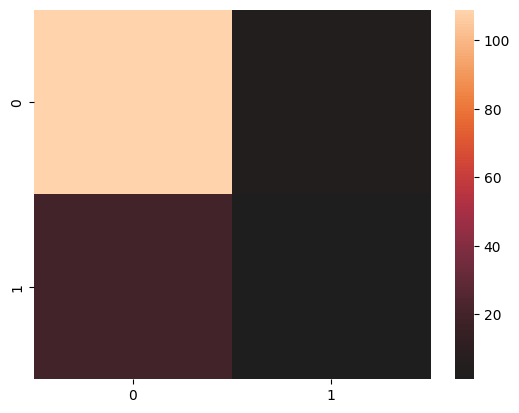

In [22]:
import seaborn as sns
sns.heatmap(confMatrix, center = True)

In [23]:
from sklearn.model_selection import GridSearchCV
# parameters
parameters = {'max_depth'    : [6,10],
             'criterion'     : ['gini', 'entropy'],
             'max_features'  : ['auto', 'sqrt', 'log2'],
             'n_estimators'  : [50,100]
# Add more parameters here for tuning
              }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, 
                    verbose = 1, n_jobs = -1, refit = True)
grid.fit(X_train, y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",
        grid.best_estimator_)
print("\n The best score across ALL searched params:\n",
        grid.best_score_)
print("\n The best parameters across ALL searched params:\n",
        grid.best_params_)
print("\n ========================================================")

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/home/docker/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=6, max_features='auto')

 The best score across ALL searched params:
 0.87239869336262

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}



/home/docker/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/docker/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/docker/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

In [ ]:
# The model did not do well & even with the best params, we are going to have 90.62% accuracy. So, at this point
# we will not go ahead with making this dataset available to other DS. So will drop the branch

spark.sql("DROP BRANCH ML_exp_new IN arctic")